In [70]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.Gaussian_beam import Guassian_beam
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import RotationallySymmetricScoreGumbelSoftQuantizedDOELayer as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import RotationallySymmetricSTEQuantizedDOELayer as STEQuantizedDOELayer
from Components.QuantizedDOE import RotationallySymmetricNaiveGumbelQuantizedDOELayer as NaiveGumbelQuantizedDOELayer
from Components.QuantizedDOE import RotationallySymmetricPSQuantizedQuantizedDOELayer as PSQuantizedDOELayer
from Components.QuantizedDOE import RotationallySymmetricFullPrecisionDOELayer
from Components.QuantizedDOE import FixDOEElement
from utils.Helper_Functions import normalize, DOE_xyz_cordinates_Generator
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn
import random

In [71]:
# Hologram parameters (high-temp resin)
epsilon = 2.66
tand = 0.03
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 1 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz

wavelengths = c0 / f2
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 4,
    'look_up_table': None,
    'num_unit': None,
    'height_constraint_max': 1 * mm,
    'tolerance': 10 * um,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 50,
    'tau_max': 5.5,
    'tau_min': 4.0
}

optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 2.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}

In [72]:
import numpy as np
from PIL import Image
from utils.Helper_Functions import normalize
import matplotlib.pyplot as plt
import torch.nn.functional as F
def define_FoM(resolution, sampling_size, wavelength, focal_length, position):
    """
    Calculates the Full-width-at-half-maximum (FWHM) by the far-field diffraction limit
    and applies it to model the point spread function (PSF) as a Gaussian function, with consistent intensity across positions.
    
    Parameters:
        resolution (tuple): The resolution of the field in pixels (height, width).
        sampling_size (float): The physical size of each pixel, in meters.
        wavelength (float): The wavelength of the light, in meters.
        focal_length (float): The focal length of the optical system, in meters.
        position (tuple): The target position in the field, in meters (x, y).
        
    Returns:
        torch.Tensor: The calculated and normalized PSF as a 2D Gaussian function over the specified field.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    height, width = resolution
    Length_x = sampling_size * width
    Length_y = sampling_size * height
    
    effective_L = torch.sqrt(torch.tensor((Length_x ** 2 + Length_y ** 2), device=device))
    NA = torch.sin(torch.atan(effective_L / (2 * focal_length)))
    FWHM = wavelength / (2 * NA)
    
    x_grid, y_grid = torch.meshgrid(torch.linspace(-Length_x / 2, Length_x / 2, steps=width, device=device),
                                    torch.linspace(-Length_y / 2, Length_y / 2, steps=height, device=device))
    
    x_position, y_position = torch.tensor(position, device=device)
    
    # Calculate the Gaussian PSF
    PSF = torch.exp(-((x_grid - x_position) ** 2 + (y_grid - y_position) ** 2) / ((FWHM*2) ** 2))
    
    # Normalize the PSF such that its maximum value is 1
    
    return normalize(PSF.unsqueeze(0).unsqueeze(0))

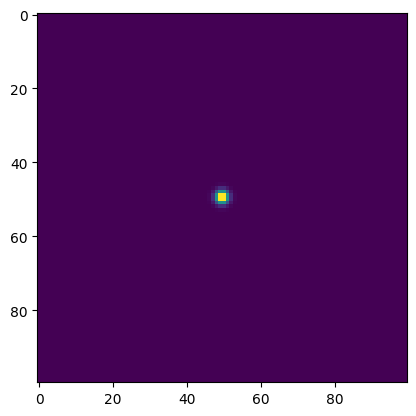

In [73]:
PSF_1 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=100*mm, position=[0*mm, 0*mm])

target = PSF_1
plt.imshow(target[0, 0, :, :].cpu())

# 1. Define the System with FullPrecisionDOE

In [94]:
class Submm_Setup_test(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 wavelengths, 
                 doe_data):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=4, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = FixDOEElement(height_map=doe_data, 
                                 tolerance=0*mm, 
                                 material=self.doe_params['material'])
        
        self.prop_range = np.linspace(20*mm, 120*mm, num=400)
        self.asm_prop3 = ASM_prop(z_distance=20 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self):
        fields_zx = []
        
        field = self.doe(self.input_field)
        final_field = self.asm_prop3(field)

        #field_data = final_field.data[0, 0, 49, :]
        #print(field_data.shape)
        #fields_zx.append(field_data)  # Use parentheses here
        
        for z in self.prop_range:
            self.asm_prop3.z = z
            final_field = self.asm_prop3(field)
            field_data = final_field.data[0, 0, 49, :]
            fields_zx.append(field_data)  # Use parentheses here

        stacked_fields_zx = torch.stack(fields_zx)
        
        return stacked_fields_zx

In [75]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=4, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = RotationallySymmetricFullPrecisionDOELayer(self.doe_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=50 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=60 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)

        self.asm_prop5 = ASM_prop(z_distance=70 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        self.asm_prop6 = ASM_prop(z_distance=80 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)

        self.asm_prop7 = ASM_prop(z_distance=90 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        final_field3 = self.asm_prop5(field)
        final_field4 = self.asm_prop6(field)
        final_field5 = self.asm_prop7(field)

        self.asm_prop3.z =50*mm + random.uniform(0*mm, 5*mm)
        self.asm_prop4.z =60*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop5.z =70*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop6.z =80*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop7.z =90*mm + random.uniform(-5*mm, 0*mm)

        
        return [final_field1, final_field2, final_field3, final_field4, final_field5]

In [76]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !


In [77]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target = target.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.02)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_field_3 = field_list[2]
    out_field_4 = field_list[3]
    out_field_5 = field_list[4]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    out_amp_3 = normalize(torch.abs(out_field_3.data)**2)
    out_amp_4 = normalize(torch.abs(out_field_4.data)**2)
    out_amp_5 = normalize(torch.abs(out_field_5.data)**2)
    loss = photometric_loss_fn(out_amp_1, target) + photometric_loss_fn(out_amp_2, target) + photometric_loss_fn(out_amp_3, target) + photometric_loss_fn(out_amp_4, target) + photometric_loss_fn(out_amp_5, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss and itr > max_itrs * 0.8:
        best_setup = setup
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2
        best_field3 = out_field_3
        best_field4 = out_field_4
        best_field5 = out_field_5

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.024771733209490776
The iteration : 200, Loss: 0.0021613393910229206
The iteration : 400, Loss: 0.0007650762563571334
The iteration : 600, Loss: 0.0005955544766038656
The iteration : 800, Loss: 0.0005880625103600323
The iteration : 1000, Loss: 0.0003743276174645871
The iteration : 1200, Loss: 0.00039306312100961804
The iteration : 1400, Loss: 0.0004103650862816721
The iteration : 1600, Loss: 0.000341827078955248
The iteration : 1800, Loss: 0.00034472334664314985
The iteration : 2000, Loss: 0.00034417706774547696
The iteration : 2200, Loss: 0.0002906423760578

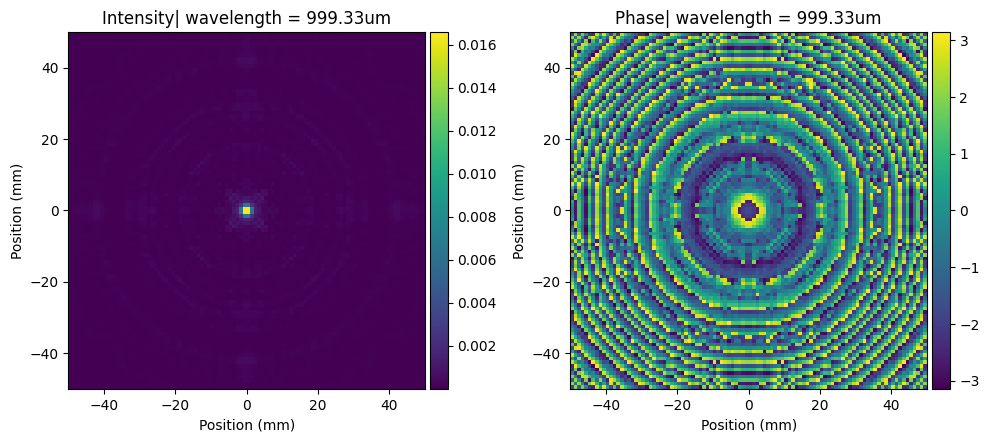

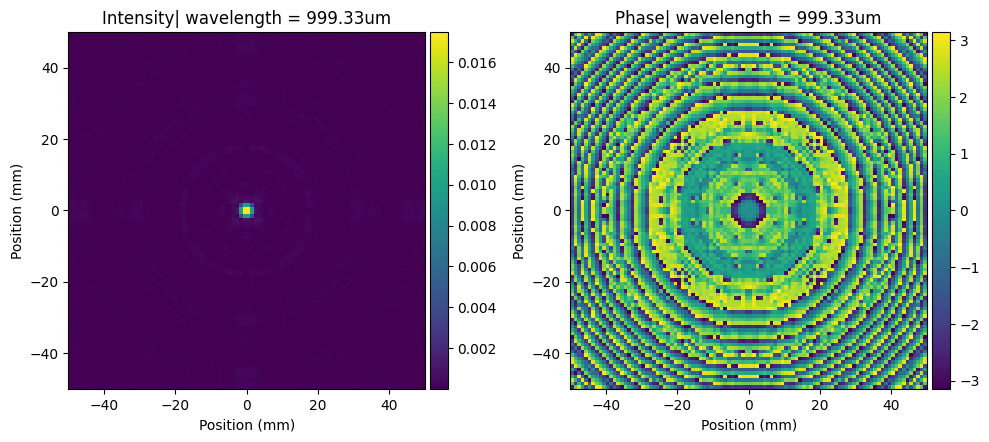

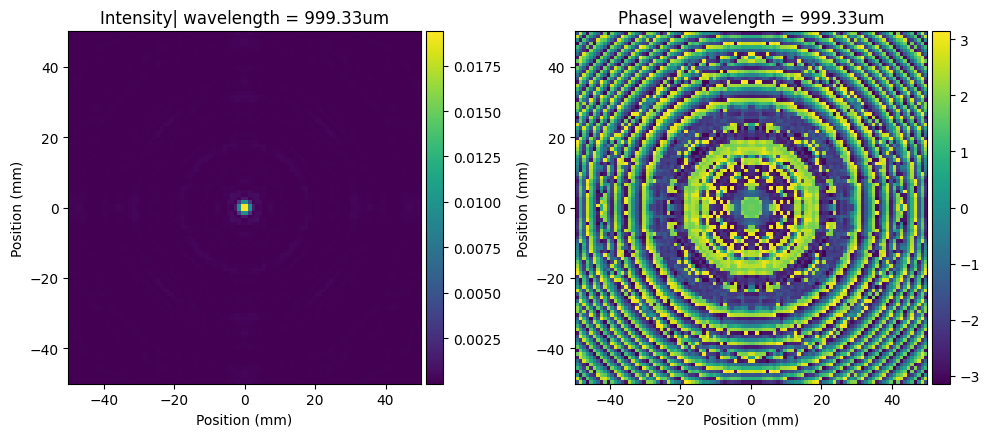

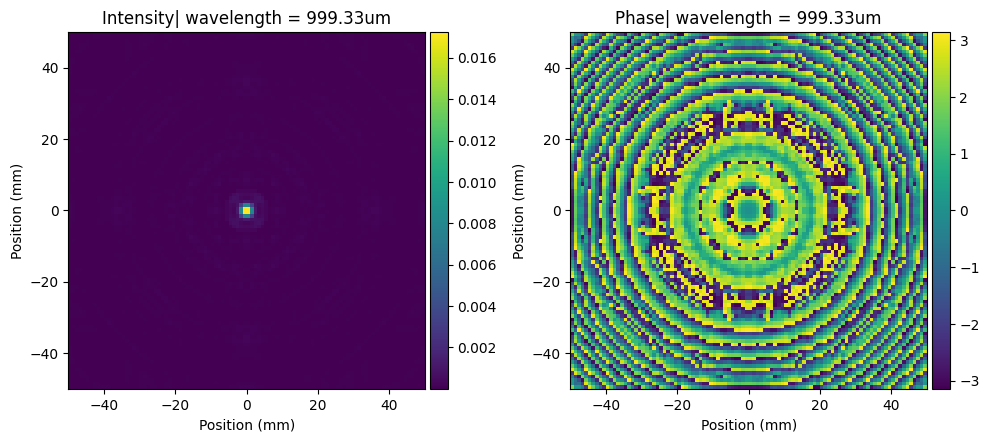

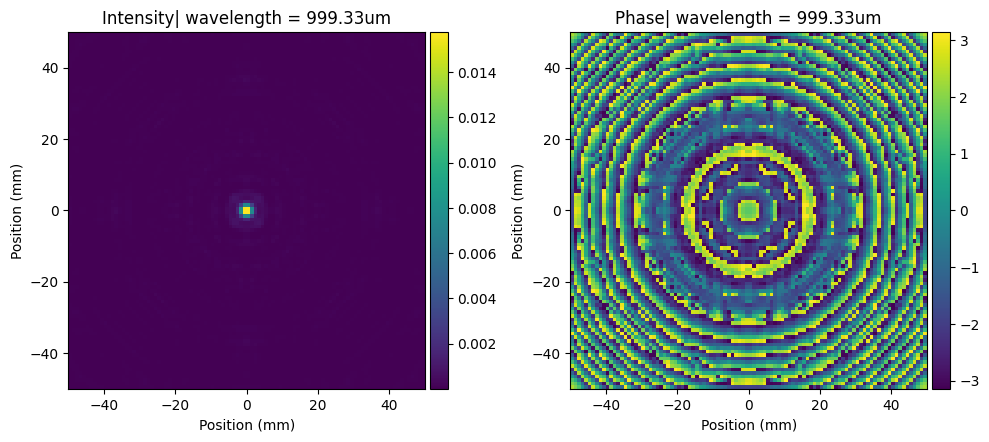

In [78]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field3.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field4.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field5.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

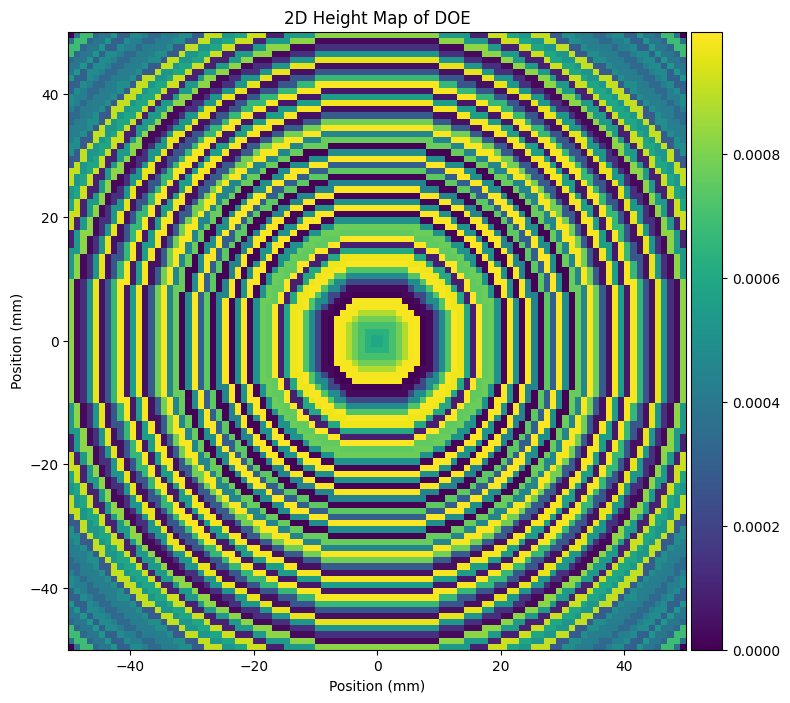

In [79]:
best_setup.doe.visualize(figsize=(8,8))

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !


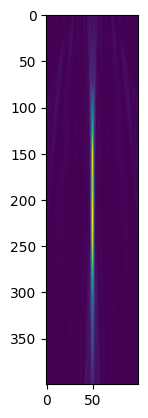

In [80]:
doe_data = setup.doe.height_map

setup_test = Submm_Setup_test(input_dxy=input_dxy, 
                              input_field_shape=input_field_shape, 
                              doe_params=doe_params, 
                              wavelengths=wavelengths, 
                              doe_data=doe_data)

data = setup_test.forward()

data = data.cpu().abs()**2


plt.imshow(data.detach().numpy())

np.save('extend_dof_full_cutoff.npy', data.detach().numpy())

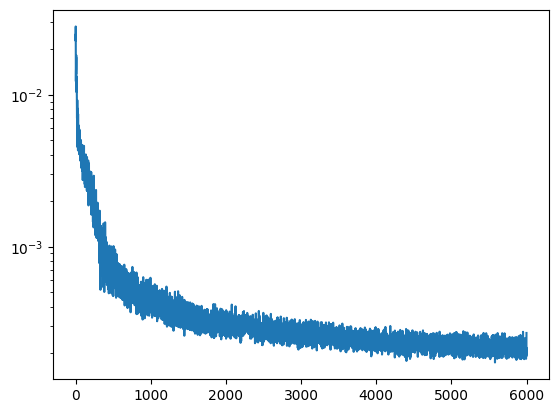

In [81]:
np.save('extend_dof_full_cutoff.npy', data.detach().numpy())

np.save('loss_curve_full.npy', losses)
plt.plot(losses)
plt.yscale('log')

In [82]:
height_map = best_setup.doe.height_map.cpu()

lut_1 = torch.tensor([0, 1, 2, 3]) * (1 * mm / 4)

lut_2 = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7]) * (1 * mm / 8)

lut_3 = torch.arange(0, 10) * (1 * mm / 10)

height_map.unique()

def quantization(input, lut):
    idx = torch.argmin(torch.abs(input.unsqueeze(-1) - lut), dim=-1)
    quantized = lut[idx]
    return quantized

In [83]:
quantized = quantization(height_map, lut_1)

quantized.unique() / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500])

In [84]:
class Submm_Setup_test(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 height_map,
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.height_map = height_map
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = FixDOEElement(height_map=self.height_map, tolerance=10*um, material=[epsilon, tand])
        
        
        self.asm_prop3 = ASM_prop(z_distance=60 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        self.asm_prop4 = ASM_prop(z_distance=80 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [37]:
setup = Submm_Setup_test(input_dxy=input_dxy, 
                      input_field_shape=input_field_shape, 
                      height_map=quantized,
                      optim_params=optim_params,
                      wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


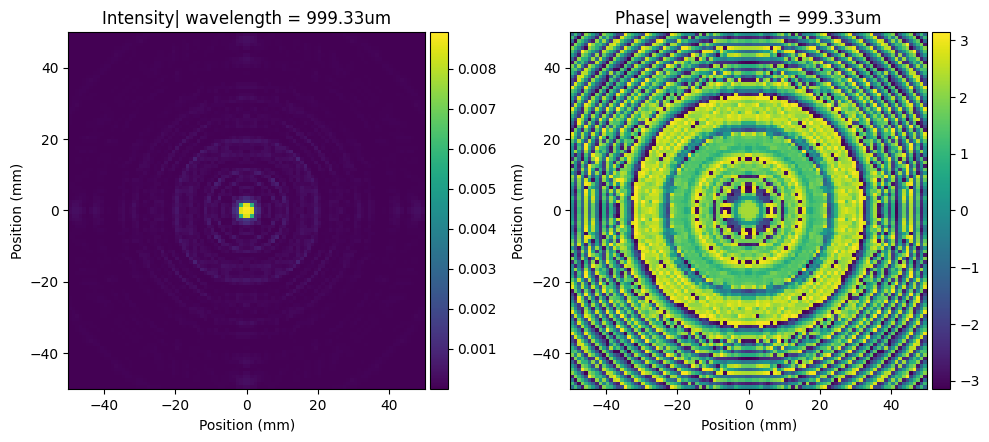

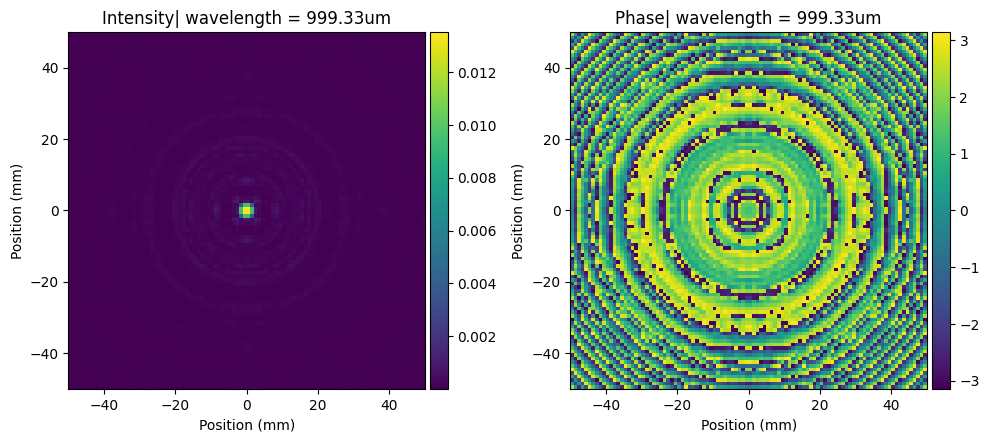

In [38]:
out_field1, out_field2 = setup.forward(iter_frac=None)
out_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
out_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

# 2. Define the System with SoftGumbelQuantizedDOE

In [85]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=50 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=60 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)

        self.asm_prop5 = ASM_prop(z_distance=70 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        self.asm_prop6 = ASM_prop(z_distance=80 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)

        self.asm_prop7 = ASM_prop(z_distance=90 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        final_field3 = self.asm_prop5(field)
        final_field4 = self.asm_prop6(field)
        final_field5 = self.asm_prop7(field)

        self.asm_prop3.z =50*mm + random.uniform(0*mm, 5*mm)
        self.asm_prop4.z =60*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop5.z =70*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop6.z =80*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop7.z =90*mm + random.uniform(-5*mm, 0*mm)
        
        return [final_field1, final_field2, final_field3, final_field4, final_field5]

In [86]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.4333979] m, the TF will be fine during the sampling !


In [87]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target = target.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.02)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_field_3 = field_list[2]
    out_field_4 = field_list[3]
    out_field_5 = field_list[4]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    out_amp_3 = normalize(torch.abs(out_field_3.data)**2)
    out_amp_4 = normalize(torch.abs(out_field_4.data)**2)
    out_amp_5 = normalize(torch.abs(out_field_5.data)**2)
    loss = photometric_loss_fn(out_amp_1, target) + photometric_loss_fn(out_amp_2, target) + photometric_loss_fn(out_amp_3, target) + photometric_loss_fn(out_amp_4, target) + photometric_loss_fn(out_amp_5, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss and itr > max_itrs * 0.8:
        best_setup = setup
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2
        best_field3 = out_field_3
        best_field4 = out_field_4
        best_field5 = out_field_5

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.08320467919111252
The iteration : 200, Loss: 0.0016042907955124974
The iteration : 400, Loss: 0.0008496275986544788
The iteration : 600, Loss: 0.0006415260140784085
The iteration : 800, Loss: 0.0005629112711176276
The iteration : 1000, Loss: 0.00037383349263109267
The iteration : 1200, Loss: 0.00034672796027734876
The iteration : 1400, Loss: 0.000419827934820205
The iteration : 1600, Loss: 0.00034461403265595436
The iteration : 1800, Loss: 0.00034418661380186677
The iteration : 2000, Loss: 0.0004207814345136285
The iteration : 2200, Loss: 0.0003709576267283

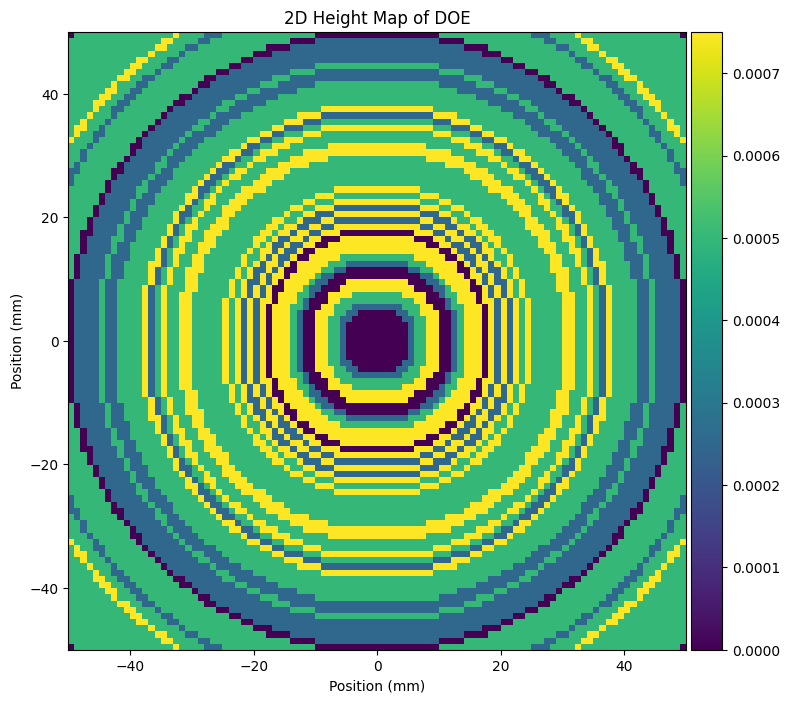

In [88]:
best_setup.doe.visualize(figsize=(8,8))

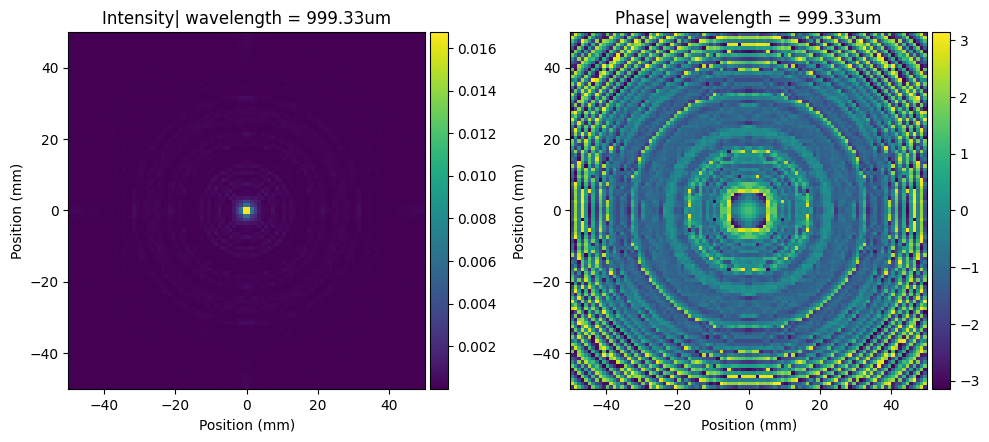

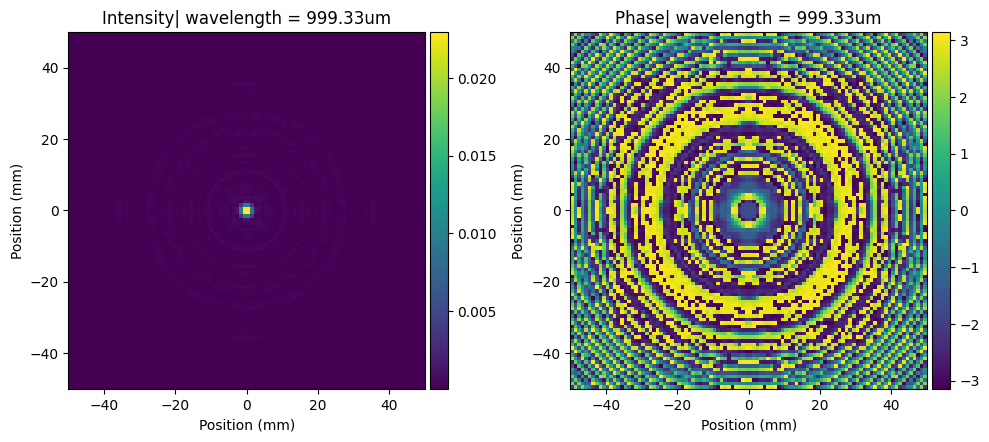

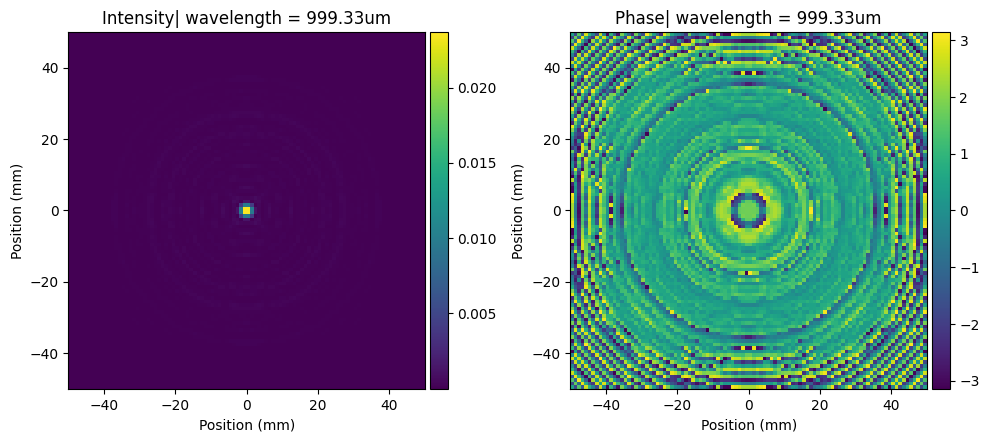

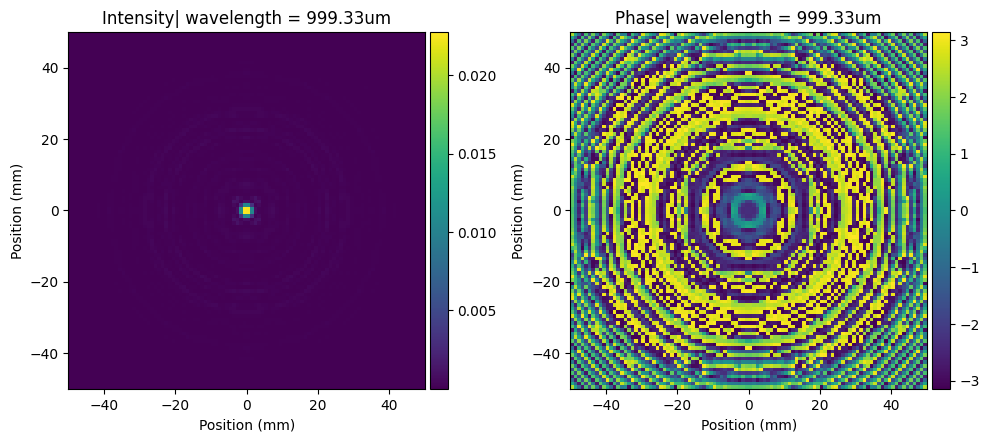

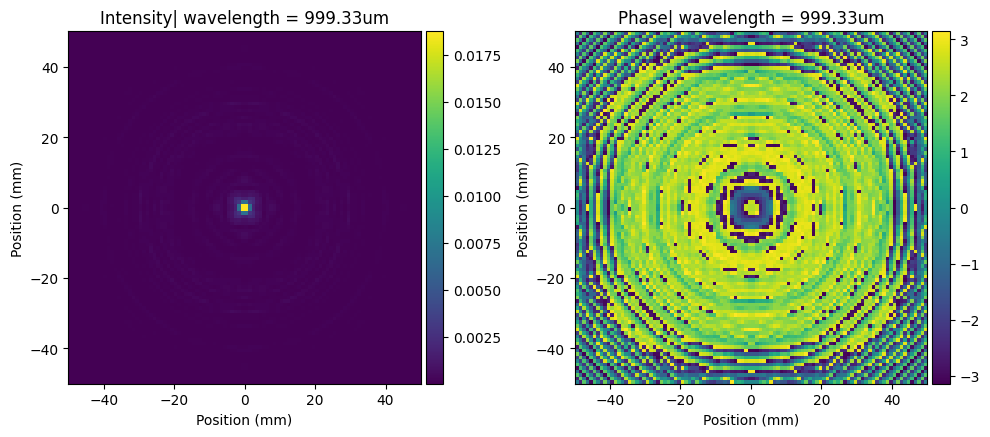

In [89]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field3.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field4.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field5.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

In [90]:
setup.doe.height_map.unique() / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500], device='cuda:0',
       grad_fn=<DivBackward0>)

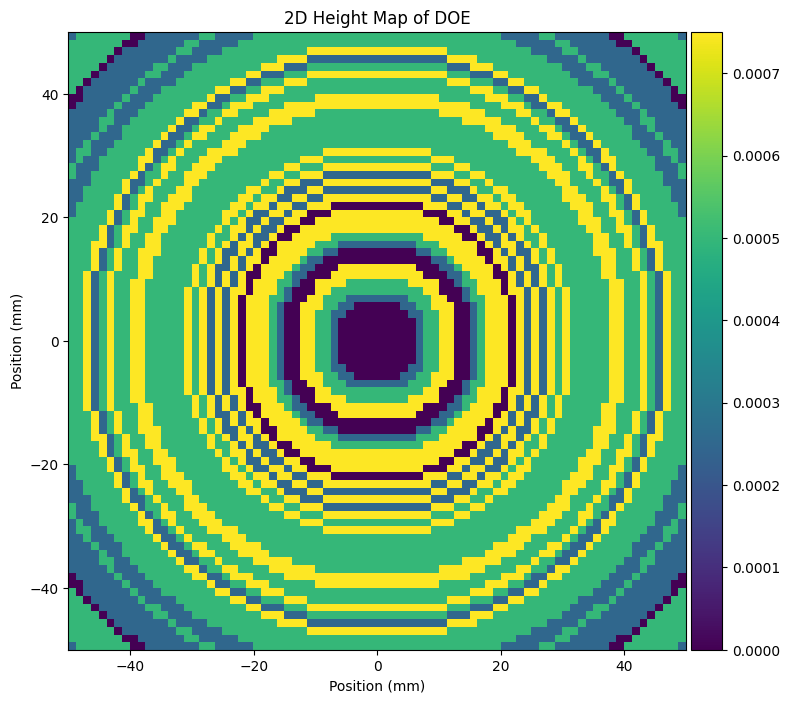

In [91]:
best_setup.doe.visualize(figsize=(8, 8), crop_size=[80, 80])

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !


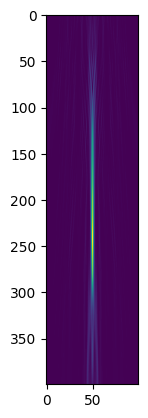

In [95]:
doe_data = best_setup.doe.height_map

setup_test = Submm_Setup_test(input_dxy=input_dxy, 
                              input_field_shape=input_field_shape, 
                              doe_params=doe_params, 
                              wavelengths=wavelengths, 
                              doe_data=doe_data)

data = setup_test.forward()

data = data.cpu().abs()**2

data = data / data.max()

plt.imshow(data.detach().numpy())

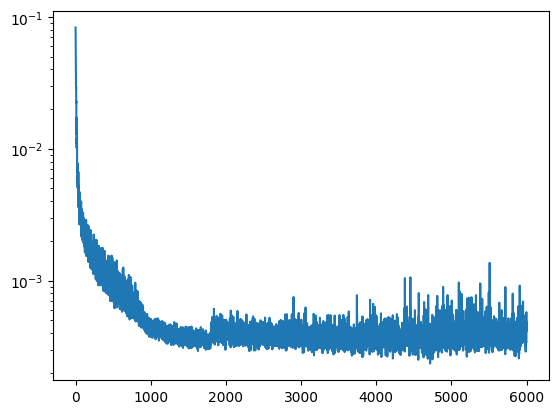

In [96]:
#best_setup.doe.save(crop_size=[80, 80])
np.save('extend_dof_Ours_cutoff.npy', data.detach().numpy())

np.save('loss_curve_Ours.npy', losses)
plt.plot(losses)
plt.yscale('log')

In [97]:
#data = np.load('height_map_20240815-144053.npy', allow_pickle=True)
#thickness = data.item().get('thickness')
#dxy = data.item().get('dxy')
#plt.imshow(thickness)
#DOE_xyz_cordinates_Generator(thickness, dxy, new_dxy=dxy)

In [98]:
data.shape

torch.Size([400, 100])

# 3. Define the System with STEQuantizedDOE

In [99]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=4, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = STEQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=50 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=60 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)

        self.asm_prop5 = ASM_prop(z_distance=70 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        self.asm_prop6 = ASM_prop(z_distance=80 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)

        self.asm_prop7 = ASM_prop(z_distance=90 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        final_field3 = self.asm_prop5(field)
        final_field4 = self.asm_prop6(field)
        final_field5 = self.asm_prop7(field)

        self.asm_prop3.z =50*mm + random.uniform(0*mm, 5*mm)
        self.asm_prop4.z =60*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop5.z =70*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop6.z =80*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop7.z =90*mm + random.uniform(-5*mm, 0*mm)
        
        return [final_field1, final_field2, final_field3, final_field4, final_field5]

In [100]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.4333979] m, the TF will be fine during the sampling !


In [101]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target = target.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.02)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_field_3 = field_list[2]
    out_field_4 = field_list[3]
    out_field_5 = field_list[4]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    out_amp_3 = normalize(torch.abs(out_field_3.data)**2)
    out_amp_4 = normalize(torch.abs(out_field_4.data)**2)
    out_amp_5 = normalize(torch.abs(out_field_5.data)**2)
    loss = photometric_loss_fn(out_amp_1, target) + photometric_loss_fn(out_amp_2, target) + photometric_loss_fn(out_amp_3, target) + photometric_loss_fn(out_amp_4, target) + photometric_loss_fn(out_amp_5, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss and itr > max_itrs * 0.8:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2
        best_field3 = out_field_3
        best_field4 = out_field_4
        best_field5 = out_field_5

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.013280757702887058
The iteration : 200, Loss: 0.001722017303109169
The iteration : 400, Loss: 0.0012525500496849418
The iteration : 600, Loss: 0.0006831986829638481
The iteration : 800, Loss: 0.0004862416535615921
The iteration : 1000, Loss: 0.0002879714302252978
The iteration : 1200, Loss: 0.0004302375018596649
The iteration : 1400, Loss: 0.0004602196568157524
The iteration : 1600, Loss: 0.0003437330888118595
The iteration : 1800, Loss: 0.00039648322854191065
The iteration : 2000, Loss: 0.00037060611066408455
The iteration : 2200, Loss: 0.00052213046001270

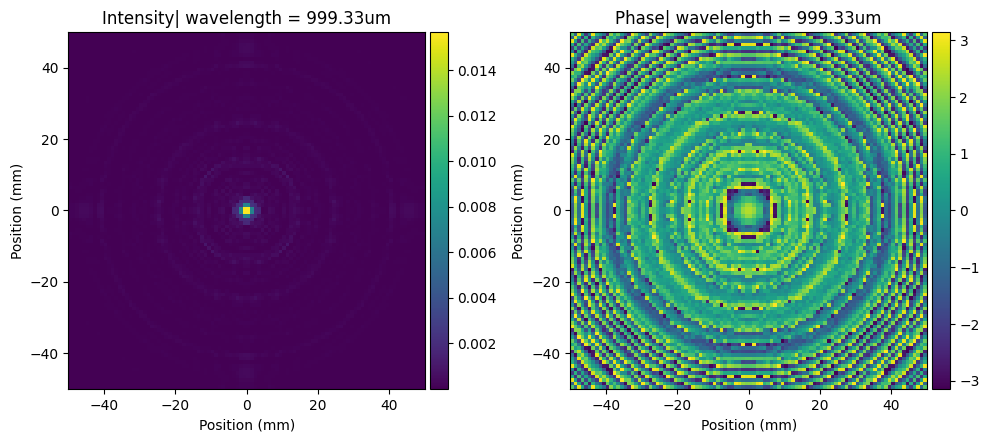

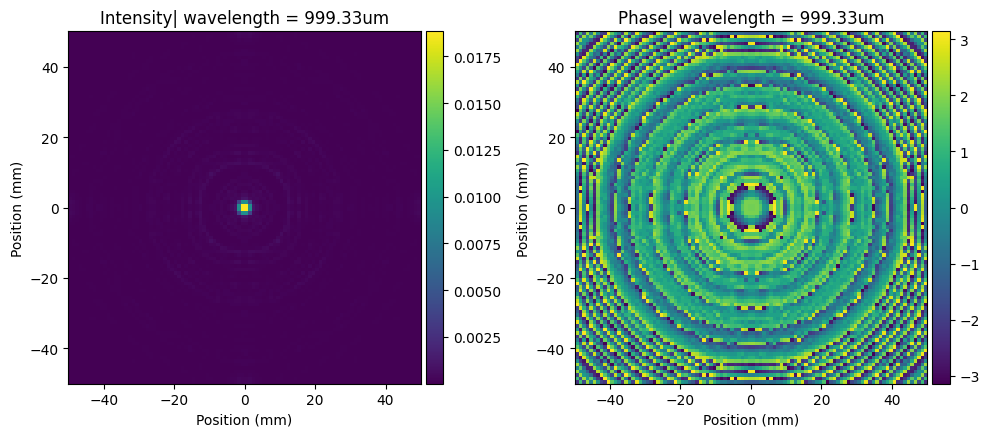

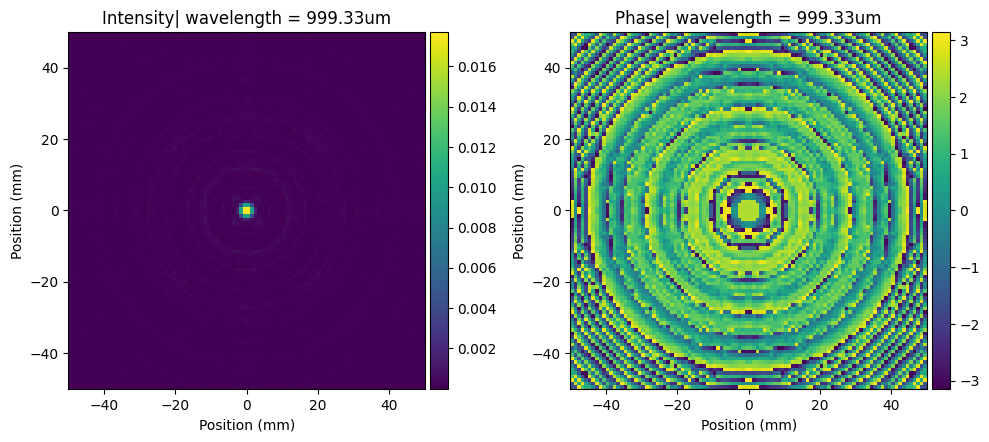

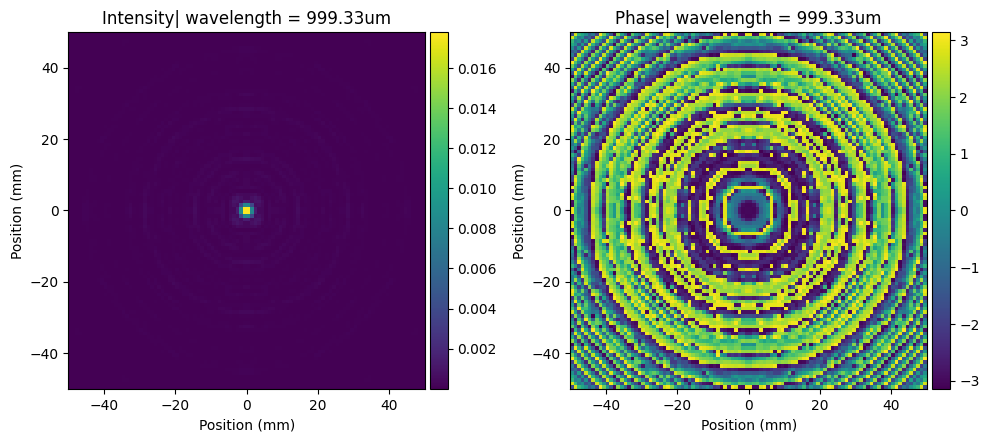

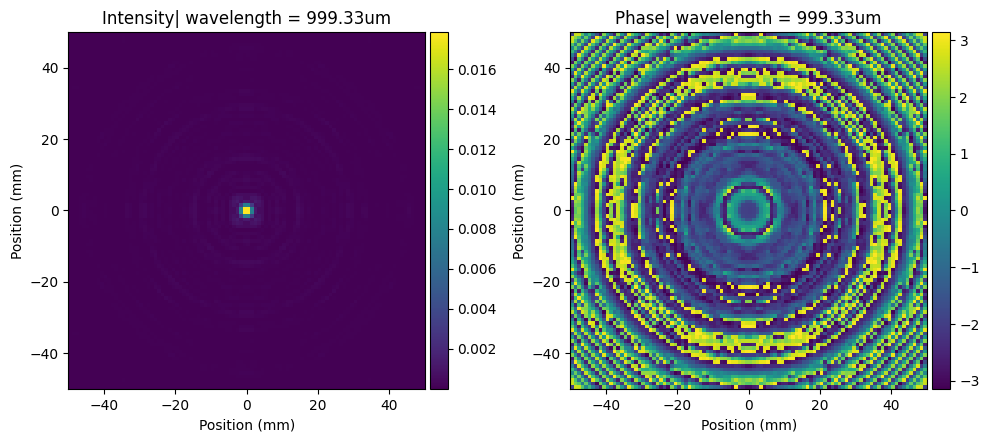

In [102]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field3.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field4.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field5.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

In [103]:
a = setup.doe.height_map

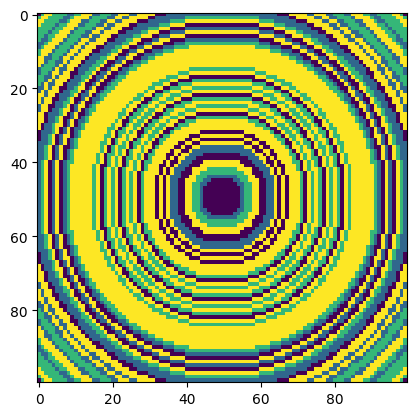

In [104]:
plt.imshow(a.cpu().detach().numpy())

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !


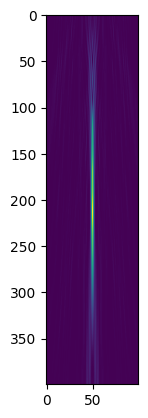

In [105]:
doe_data = setup.doe.height_map

setup_test = Submm_Setup_test(input_dxy=input_dxy, 
                              input_field_shape=input_field_shape, 
                              doe_params=doe_params, 
                              wavelengths=wavelengths, 
                              doe_data=doe_data)

data = setup_test.forward()

data = data.cpu().abs()**2

data = data / data.max()

plt.imshow(data.detach().numpy())

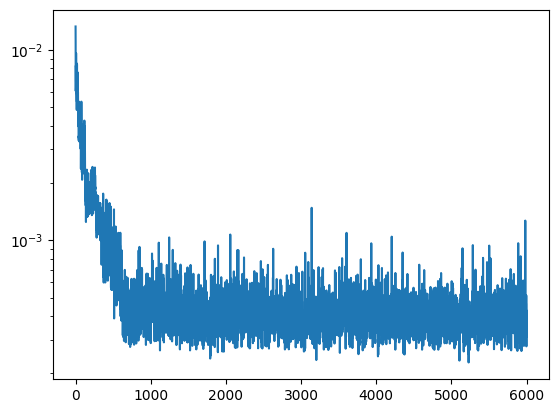

In [106]:
np.save('extend_dof_STE_cutoff.npy', data.detach().numpy())

np.save('loss_curve_STE.npy', losses)
plt.plot(losses)
plt.yscale('log')

# 4. Define the System with NaiveGumbelQuantizedDOE

In [107]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=4, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = NaiveGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=50 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=60 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)

        self.asm_prop5 = ASM_prop(z_distance=70 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        self.asm_prop6 = ASM_prop(z_distance=80 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)

        self.asm_prop7 = ASM_prop(z_distance=90 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        final_field3 = self.asm_prop5(field)
        final_field4 = self.asm_prop6(field)
        final_field5 = self.asm_prop7(field)

        self.asm_prop3.z =50*mm + random.uniform(0*mm, 5*mm)
        self.asm_prop4.z =60*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop5.z =70*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop6.z =80*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop7.z =90*mm + random.uniform(-5*mm, 0*mm)
        
        return [final_field1, final_field2, final_field3, final_field4, final_field5]

In [108]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.4333979] m, the TF will be fine during the sampling !


In [109]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target = target.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=0.02)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_field_3 = field_list[2]
    out_field_4 = field_list[3]
    out_field_5 = field_list[4]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    out_amp_3 = normalize(torch.abs(out_field_3.data)**2)
    out_amp_4 = normalize(torch.abs(out_field_4.data)**2)
    out_amp_5 = normalize(torch.abs(out_field_5.data)**2)
    loss = photometric_loss_fn(out_amp_1, target) + photometric_loss_fn(out_amp_2, target) + photometric_loss_fn(out_amp_3, target) + photometric_loss_fn(out_amp_4, target) + photometric_loss_fn(out_amp_5, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2
        best_field3 = out_field_3
        best_field4 = out_field_4
        best_field5 = out_field_5

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.009006030857563019
The iteration : 200, Loss: 0.003064114134758711
The iteration : 400, Loss: 0.003399231703951955
The iteration : 600, Loss: 0.0038389733526855707
The iteration : 800, Loss: 0.00490465248003602
The iteration : 1000, Loss: 0.0006736659561283886
The iteration : 1200, Loss: 0.0010270981583744287
The iteration : 1400, Loss: 0.0006572146667167544
The iteration : 1600, Loss: 0.0013759942958131433
The iteration : 1800, Loss: 0.0012595683801919222
The iteration : 2000, Loss: 0.0009027620544657111
The iteration : 2200, Loss: 0.001221862155944109
The

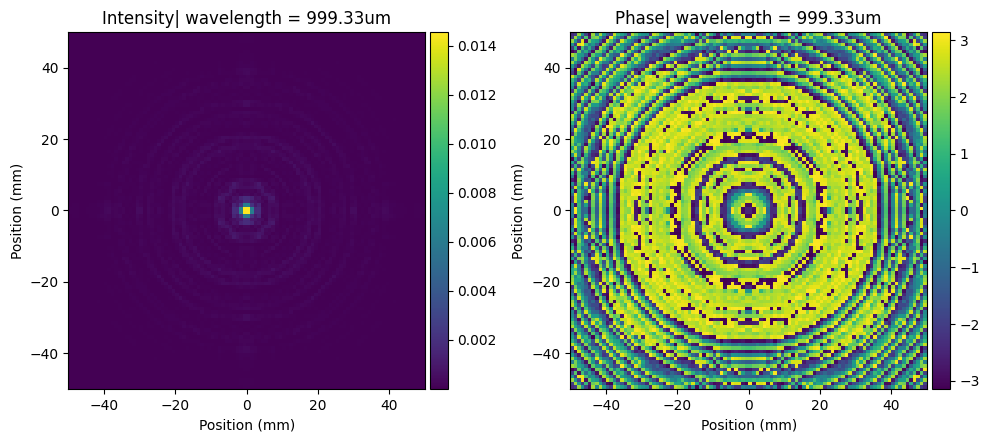

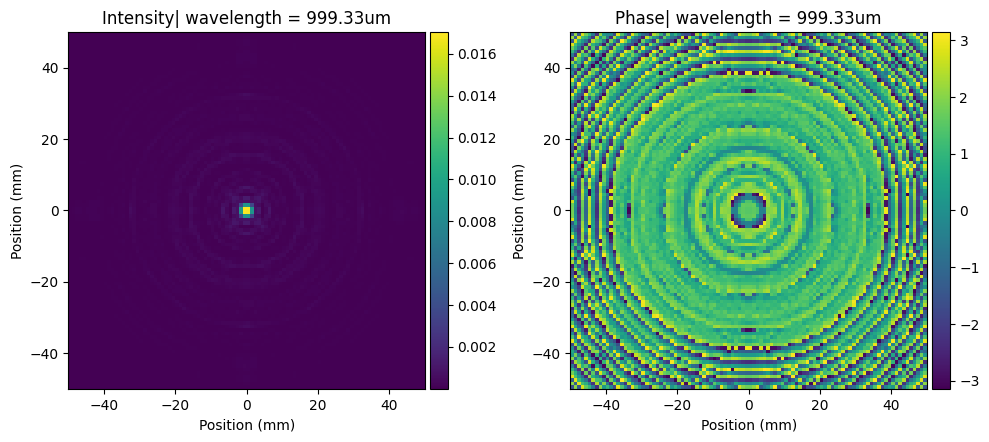

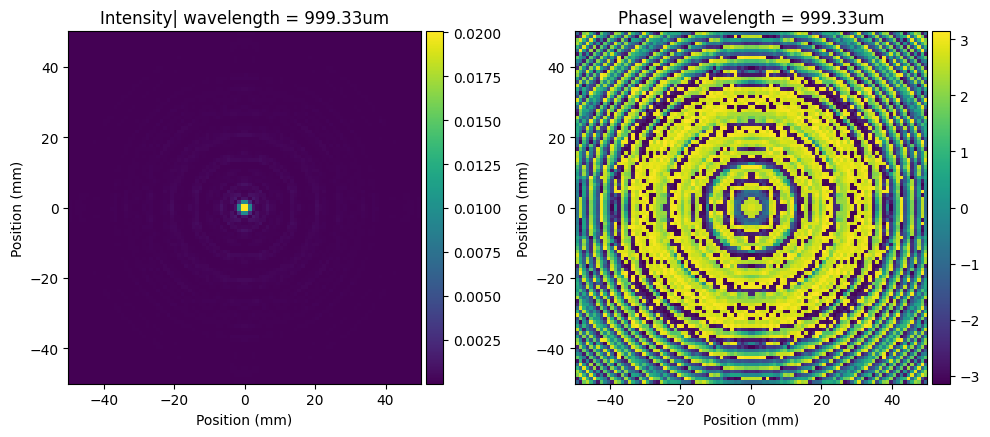

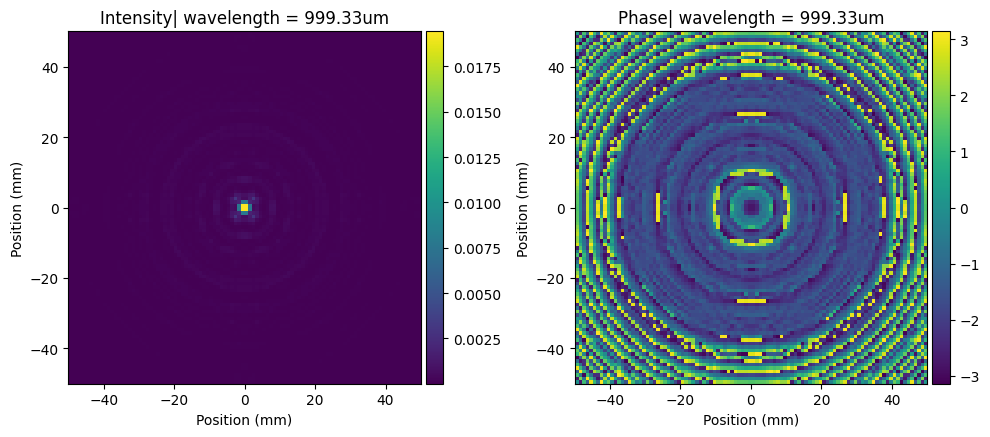

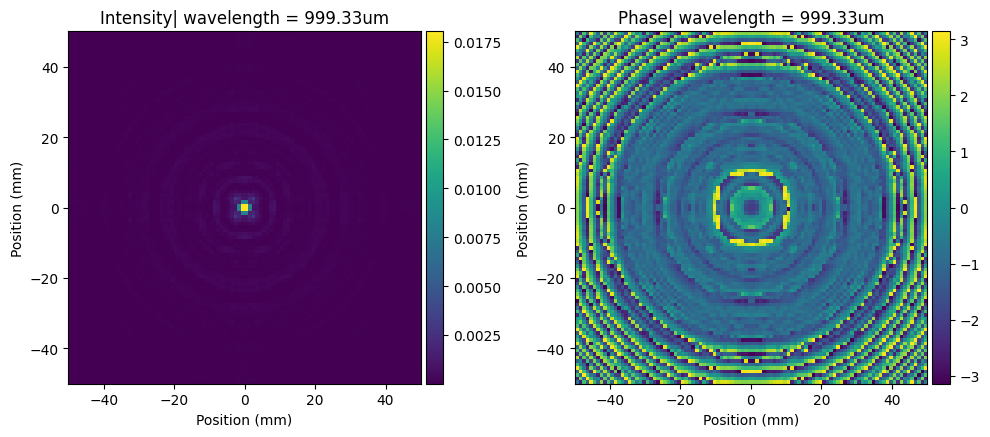

In [110]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field3.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field4.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field5.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

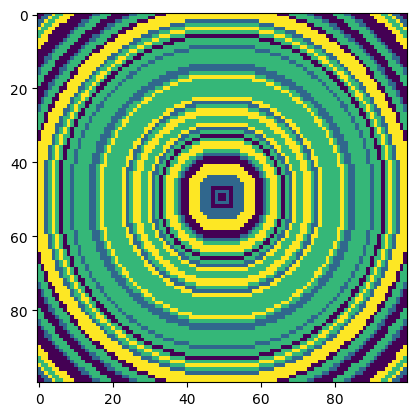

In [111]:
a = setup.doe.height_map
plt.imshow(a.cpu().detach().numpy())

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !


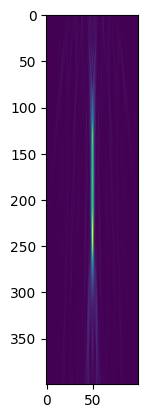

In [112]:
doe_data = best_setup.doe.height_map

setup_test = Submm_Setup_test(input_dxy=input_dxy, 
                              input_field_shape=input_field_shape, 
                              doe_params=doe_params, 
                              wavelengths=wavelengths, 
                              doe_data=doe_data)

data = setup_test.forward()

data = data.cpu().abs()**2

data = data / data.max()

plt.imshow(data.detach().numpy())

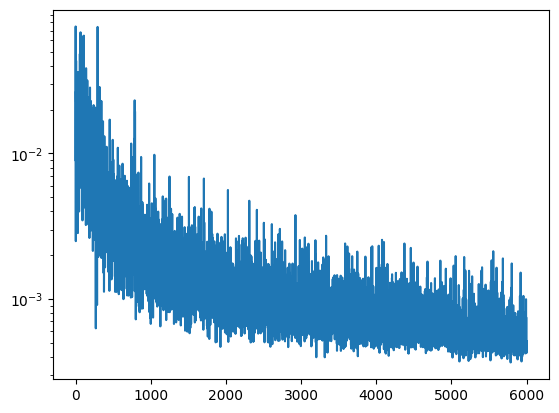

In [113]:
np.save('extend_dof_GQ_cutoff.npy', data.detach().numpy())

np.save('loss_curve_GQ.npy', losses)
plt.plot(losses)
plt.yscale('log')

# 5. Define the System with PSQQuantizedDOE

In [114]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=4, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = PSQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=50 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=60 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)

        self.asm_prop5 = ASM_prop(z_distance=70 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        self.asm_prop6 = ASM_prop(z_distance=80 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)

        self.asm_prop7 = ASM_prop(z_distance=90 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        final_field3 = self.asm_prop5(field)
        final_field4 = self.asm_prop6(field)
        final_field5 = self.asm_prop7(field)

        self.asm_prop3.z =50*mm + random.uniform(0*mm, 5*mm)
        self.asm_prop4.z =60*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop5.z =70*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop6.z =80*mm + random.uniform(-5*mm, 5*mm)
        self.asm_prop7.z =90*mm + random.uniform(-5*mm, 0*mm)
        
        return [final_field1, final_field2, final_field3, final_field4, final_field5]

In [115]:
optim_params = {
    'c_s': 300,
    'tau_max': 400,
    'tau_min': 1
}
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.4333979] m, the TF will be fine during the sampling !


In [116]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target = target.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=0.02)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_field_3 = field_list[2]
    out_field_4 = field_list[3]
    out_field_5 = field_list[4]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    out_amp_3 = normalize(torch.abs(out_field_3.data)**2)
    out_amp_4 = normalize(torch.abs(out_field_4.data)**2)
    out_amp_5 = normalize(torch.abs(out_field_5.data)**2)
    loss = photometric_loss_fn(out_amp_1, target) + photometric_loss_fn(out_amp_2, target) + photometric_loss_fn(out_amp_3, target) + photometric_loss_fn(out_amp_4, target) + photometric_loss_fn(out_amp_5, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss and itr > max_itrs * 0.8:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2
        best_field3 = out_field_3
        best_field4 = out_field_4
        best_field5 = out_field_5

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.21340782940387726
The iteration : 200, Loss: 0.004237240180373192
The iteration : 400, Loss: 0.0023320973850786686
The iteration : 600, Loss: 0.002968436572700739
The iteration : 800, Loss: 0.0015132164116948843
The iteration : 1000, Loss: 0.0027965251356363297
The iteration : 1200, Loss: 0.002717701718211174
The iteration : 1400, Loss: 0.0017795758321881294
The iteration : 1600, Loss: 0.002909020520746708
The iteration : 1800, Loss: 0.0017982089193537831
The iteration : 2000, Loss: 0.0028306427411735058
The iteration : 2200, Loss: 0.0019617376383394003
The

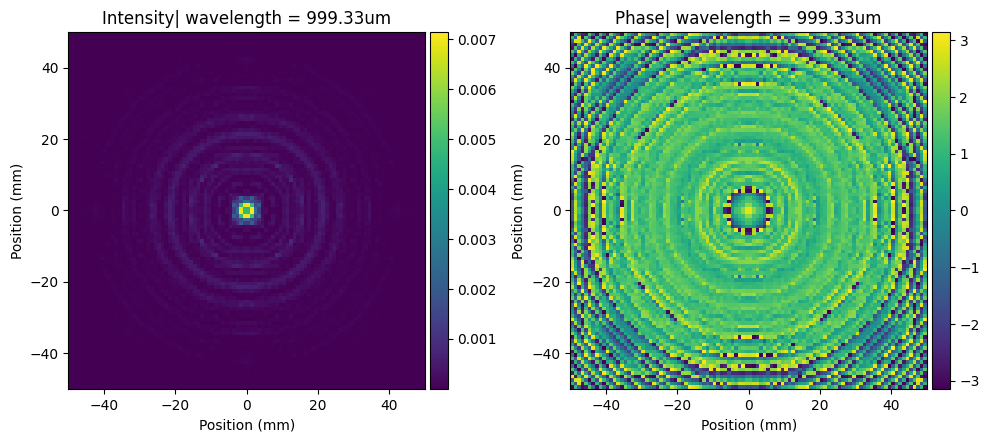

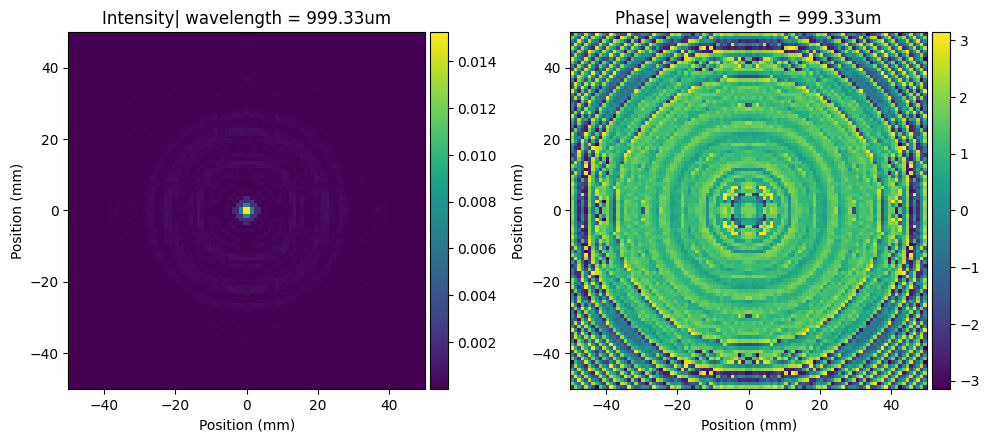

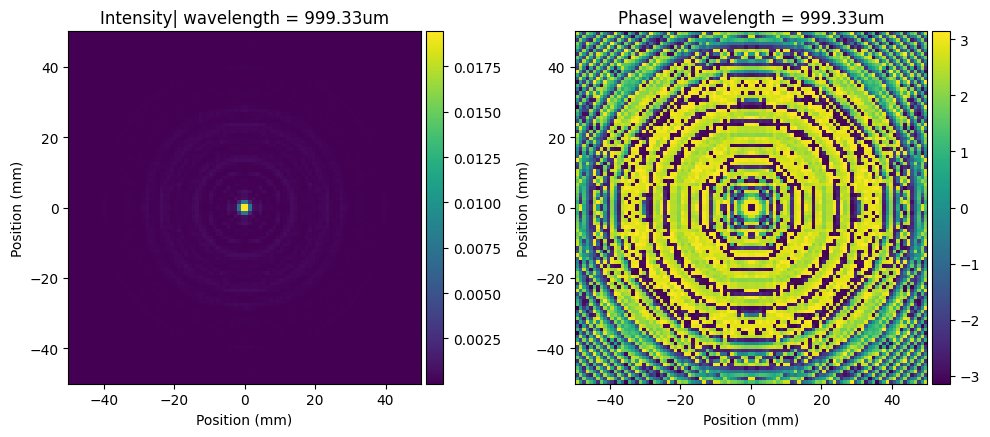

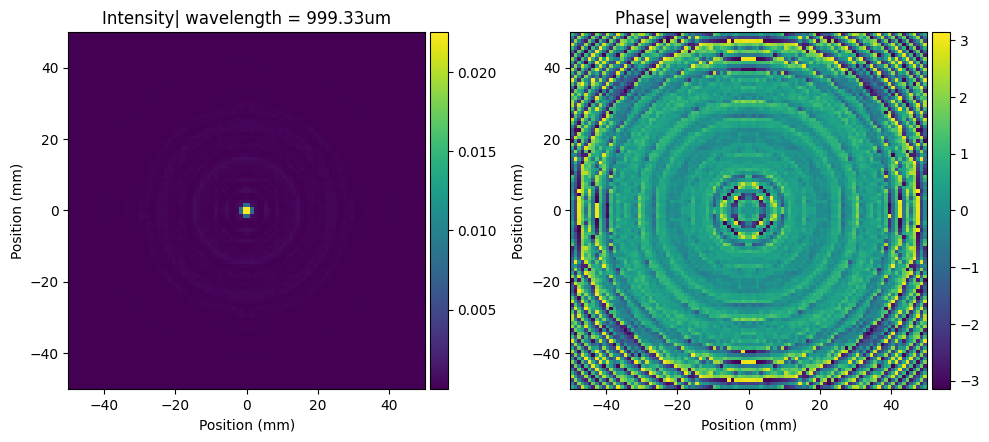

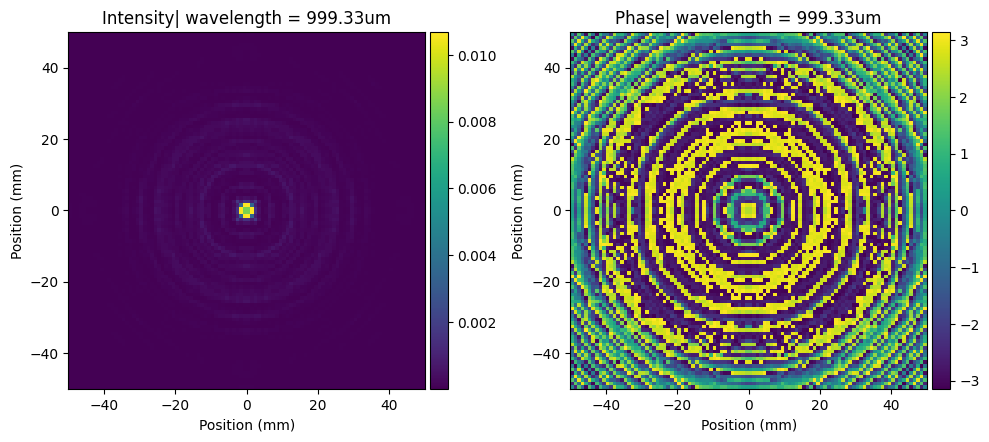

In [117]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field3.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field4.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field5.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

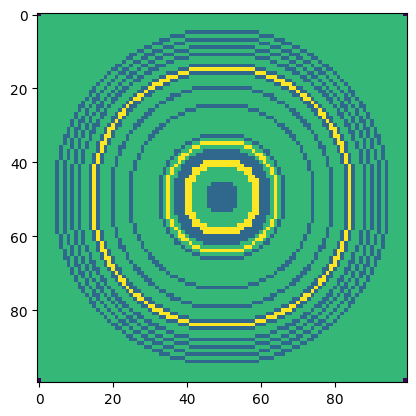

In [118]:
a = setup.doe.height_map
plt.imshow(a.cpu().detach().numpy())

In [119]:
setup.doe.height_map.unique()

tensor([0.0000, 0.0003, 0.0007, 0.0010], device='cuda:0',
       grad_fn=<Unique2Backward0>)

The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !
The critical distance is [0.4333979] m, the TF will be fine during the sampling !


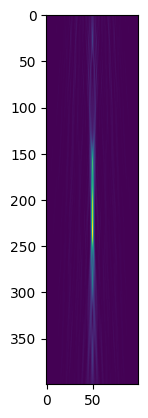

In [120]:
doe_data = setup.doe.height_map

setup_test = Submm_Setup_test(input_dxy=input_dxy, 
                              input_field_shape=input_field_shape, 
                              doe_params=doe_params, 
                              wavelengths=wavelengths, 
                              doe_data=doe_data)

data = setup_test.forward()

data = data.cpu().abs()**2

data = data / data.max()

plt.imshow(data.detach().numpy())

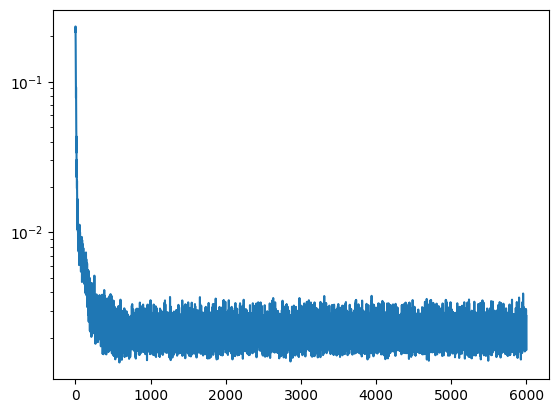

In [121]:
np.save('extend_dof_PSQ_cutoff.npy', data.detach().numpy())

np.save('loss_curve_PSQ.npy', losses)
plt.plot(losses)
plt.yscale('log')